# Measuring the applicants gap

Each school has a determined set of characteristics. Based on these characteristics, we can estimate how many students from each school will sit for SHSAT. Based on this estimation, we come up with a gap, that is the difference between the expected amount of SHSAT takers and the actual amount. PASSNYC actions should be made upon this gap, and its effect can be estimated based upon the size of this gap. So, in this kernel here, I will estimate the applicants gap for each school, providing a good parameter for PASSNYC when it is going to choose new schools. How far from schools with the same characteristics this school is...

**Assumptions**:

- The number of SHSAT applicants for each school keeps somewhat constant

# Data

To create this model, I will joined dataset from a variety of sources. The main objective was to gather information from the schools and students that had the opportunity to take the SHSAT in the end of 2017.

![data timeline](../data/keep/timeline.png)

## School Locations

Latitude and longitude for each school. From these, I could also extract the borough each school is located at.

## Test results

NYS Tests Results for ELA (English Language Arts) and Math. Our focus group took them on the 7th grade in 2017.

## SHSAT Testers and Offers

Contains the amount of SHSAT Testers and offers for each school in 2017

## Quality Report

We used it to extract demographics information for each school for the 2016-17 school year.

*Wouldn't it be better to use the 2017-18 demographics?*

-- compare with direct demographics --

Overall, it may be the right choice, as the quality reports *seems* to use data from the end of the year for their demographics assessments.

# Prepare the data

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
from patsy import dmatrices
from scipy.special import logit, expit
from sklearn.linear_model import HuberRegressor, LinearRegression
from sklearn.metrics import mean_squared_error, median_absolute_error

pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', None)

In [2]:
def psize(df):
    print("rows = {}".format(df.shape[0]))

# select columns
df = pd.read_pickle('../data/process/schools2017.pkl')
hs_admissions_counts = df['# Students in HS Admissions']
df = df[[
    'Charter School?',
    'Percent Asian',
    'Percent Black',
    'Percent Hispanic',
    'Percent Other',
    'Percent English Language Learners',
    'Percent Students with Disabilities',
    'Economic Need Index',
    'Mean Scale Score - ELA',
    '% Level 2 - ELA',
    '% Level 3 - ELA',
    '% Level 4 - ELA',
    'Mean Scale Score - Math',
    '% Level 2 - Math',
    '% Level 3 - Math',
    '% Level 4 - Math',
    'Percent of Students Chronically Absent',
    '% SHSAT Testers',
]]

psize(df)
df.head()

rows = 594


,Charter School?,Percent Asian,Percent Black,Percent Hispanic,Percent Other,Percent English Language Learners,Percent Students with Disabilities,Economic Need Index,Mean Scale Score - ELA,% Level 2 - ELA,% Level 3 - ELA,% Level 4 - ELA,Mean Scale Score - Math,% Level 2 - Math,% Level 3 - Math,% Level 4 - Math,Percent of Students Chronically Absent,% SHSAT Testers
DBN,,,,,,,,,,,,,,,,,,
01M034,0.0,0.053,0.297,0.614,0.006,0.080,0.380,0.872,298.2778,59.25926,22.22222,1.851852,285.9423,34.61538,13.46154,0.000000,0.305,0.103448
01M140,0.0,0.044,0.121,0.794,0.011,0.124,0.338,0.853,297.4545,60.00000,21.81818,1.818182,291.2456,38.59649,14.03509,0.000000,0.395,0.089552
01M184,0.0,0.697,0.044,0.124,0.050,0.171,0.192,0.560,330.1358,20.98765,39.50617,34.567900,339.6988,16.86747,28.91566,44.578310,0.041,0.761364
01M188,0.0,0.019,0.320,0.625,0.000,0.154,0.332,0.938,295.6667,45.09804,15.68627,1.960784,294.5000,46.15385,21.15385,0.000000,0.369,NaN
01M301,0.0,0.087,0.323,0.496,0.039,0.047,0.441,0.746,304.7073,46.34146,31.70732,4.878049,288.1951,36.58537,12.19512,2.439024,0.382,0.215686


Drop rows where the percentage SHSAT testers is unknown (from 0 to 5).

In [3]:
df = df[df['% SHSAT Testers'].notnull()]
psize(df)

rows = 537


Drop rows with other unknown values.

In [4]:
df = df[df.notnull().all(axis=1)]
psize(df)

rows = 523


# Create a model

In this first model, I will use a logit regression... Kinda like linear regression, but the output variables are transformed before because it was a percentage.

In [5]:
inputs = df.iloc[:, :-1]
outputs = logit(df.iloc[:, -1])

## Simple demonstration

The Math scores of each school can be used as a predictor for the amount of SHSAT takers.

R2 Score: 0.5461295925419097


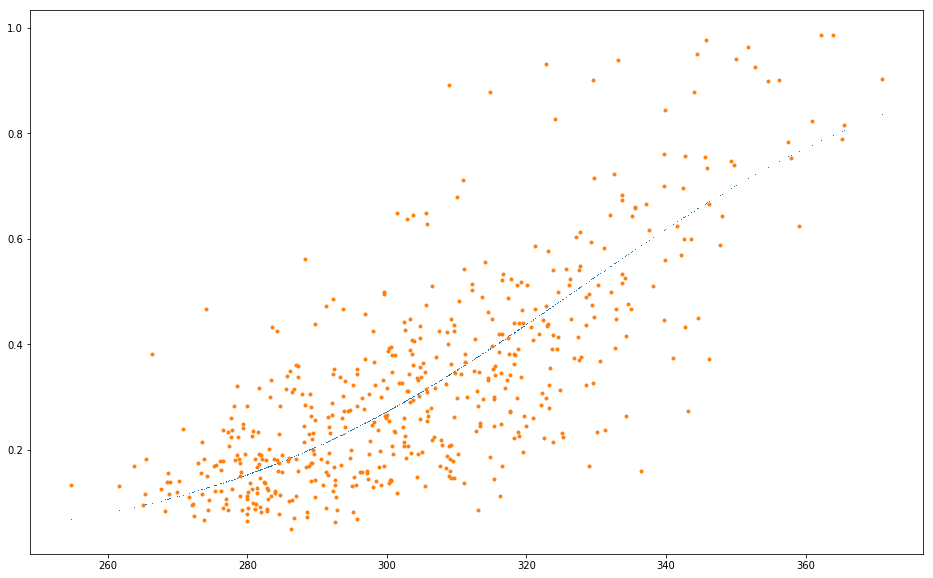

In [6]:
model = LinearRegression()
model.fit(inputs[['Mean Scale Score - Math']], outputs)
predictions = model.predict(inputs[['Mean Scale Score - Math']])

plt.figure(figsize=(16,10))
plt.plot(inputs['Mean Scale Score - Math'], expit(predictions), ',')
plt.plot(inputs['Mean Scale Score - Math'], expit(outputs), '.')

print("R2 Score: {}".format(model.score(inputs[['Mean Scale Score - Math']], outputs)))

When we use more data, we will get better results. Also, as we want to identify schools that are deviant from the expected, it is wise to reduce their effects on the model, so we can visualizze them better. For this, we will use a kind of robust regression (regression that is less sensitve to outliers), called Huber regressor.

## Find model parameters

Since this is a robust regression, we can control for the amount of robustness that we want. For doing so, I will visualize how much the MAD (median absolute deviation) and the mean squared error change, while changing the value of epsilon.

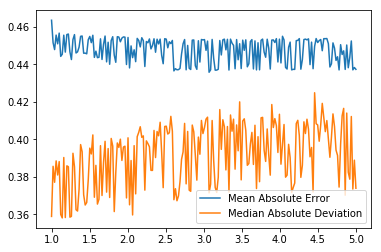

In [7]:
params = np.linspace(1, 5, 200)
mae = []
mad = []

for param in params:
    model = HuberRegressor(param)
    model.fit(inputs, outputs)
    predictions = model.predict(inputs)
    mae.append(mean_squared_error(outputs, predictions))
    mad.append(median_absolute_error(outputs, predictions))

fig, ax = plt.subplots()
ax.plot(params, mae, label='Mean Absolute Error')
ax.plot(params, mad, label="Median Absolute Deviation")
plt.legend()

We want to reduce the MAD while keeping the MAE somewhat the same. Best guess is for tiny values of eps, as the MAE doesn't get too high.

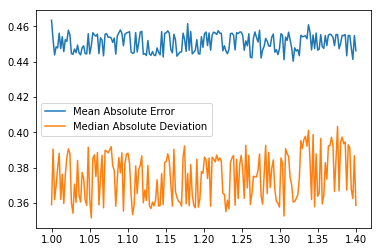

In [8]:
params = np.linspace(1, 1.4, 200)
mae = []
mad = []

for param in params:
    model = HuberRegressor(param)
    model.fit(inputs, outputs)
    predictions = model.predict(inputs)
    mae.append(mean_squared_error(outputs, predictions))
    mad.append(median_absolute_error(outputs, predictions))

fig, ax = plt.subplots()
ax.plot(params, mae, label='Mean Absolute Error')
ax.plot(params, mad, label="Median Absolute Deviation")
plt.legend()

Let's hit that apparent min

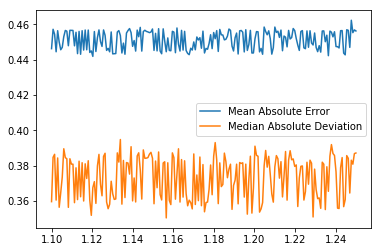

In [9]:
params = np.linspace(1.10, 1.25, 200)
mae = []
mad = []

for param in params:
    model = HuberRegressor(param)
    model.fit(inputs, outputs)
    predictions = model.predict(inputs)
    mae.append(mean_squared_error(outputs, predictions))
    mad.append(median_absolute_error(outputs, predictions))

fig, ax = plt.subplots()
ax.plot(params, mae, label='Mean Absolute Error')
ax.plot(params, mad, label="Median Absolute Deviation")
plt.legend()

1.15 is our value

## Variable importance

To assess variable importance, we will use a statsmodel regression (which is more "featured" than those of sklearn).

In [11]:
y = outputs.copy()
x = inputs.copy()

x['Constant'] = 1.0
x['Mean Scale Score - ELA ** 2'] = x['Mean Scale Score - ELA'] ** 2
x['Mean Scale Score - Math ** 2'] = x['Mean Scale Score - Math'] ** 2  # TODO: scale before squaring
# x['Mean Scale Score - ELA ** 3'] = x['Mean Scale Score - ELA'] ** 3
# x['Mean Scale Score - Math ** 3'] = x['Mean Scale Score - Math'] ** 3  they start assuming the value of the constant

mod = sm.RLM(y, x, M=sm.robust.norms.HuberT(1.15))
res = mod.fit()

print(median_absolute_error(y, res.fittedvalues))
res.summary()

0.36168779828702635


<class 'statsmodels.iolib.summary.Summary'>
"""
                    Robust linear Model Regression Results                    
==============================================================================
Dep. Variable:        % SHSAT Testers   No. Observations:                  523
Model:                            RLM   Df Residuals:                      503
Method:                          IRLS   Df Model:                           19
Norm:                          HuberT                                         
Scale Est.:                       mad                                         
Cov Type:                          H1                                         
Date:                Wed, 01 Aug 2018                                         
Time:                        16:24:33                                         
No. Iterations:                    27                                         
==========================================================================================================
                                             coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------
Charter School?                            0.1554      0.086      1.817      0.069      -0.012       0.323
Percent Asian                              0.5628      0.293      1.921      0.055      -0.011       1.137
Percent Black                              0.4453      0.252      1.765      0.078      -0.049       0.940
Percent Hispanic                          -0.2417      0.283     -0.853      0.393      -0.797       0.313
Percent Other                              0.0507      1.140      0.044      0.965      -2.184       2.285
Percent English Language Learners          0.2966      0.438      0.677      0.498      -0.562       1.155
Percent Students with Disabilities        -1.5630      0.480     -3.256      0.001      -2.504      -0.622
Economic Need Index                        0.5503      0.309      1.781      0.075      -0.055       1.156
Mean Scale Score - ELA                     0.0181      0.095      0.189      0.850      -0.169       0.205
% Level 2 - ELA                           -0.0087      0.009     -0.986      0.324      -0.026       0.009
% Level 3 - ELA                           -0.0019      0.012     -0.167      0.867      -0.025       0.021
% Level 4 - ELA                            0.0030      0.018      0.170      0.865      -0.032       0.038
Mean Scale Score - Math                    0.1498      0.068      2.212      0.027       0.017       0.283
% Level 2 - Math                          -0.0061      0.007     -0.855      0.392      -0.020       0.008
% Level 3 - Math                           0.0067      0.009      0.772      0.440      -0.010       0.024
% Level 4 - Math                           0.0313      0.014      2.278      0.023       0.004       0.058
Percent of Students Chronically Absent    -0.2595      0.392     -0.662      0.508      -1.028       0.509
Constant                                 -28.6380     12.960     -2.210      0.027     -54.039      -3.237
Mean Scale Score - ELA ** 2             8.983e-06      0.000      0.057      0.955      -0.000       0.000
Mean Scale Score - Math ** 2              -0.0003      0.000     -2.298      0.022      -0.000   -3.85e-05
==========================================================================================================

If the model instance has been used for another fit with different fit
parameters, then the fit options might not be the correct ones anymore .
"""

Here we can see variables that matter and variables that don't. I will stop by now since this kernel is preliminary and do a detailed explanation in later versions.

*it looks like ELA/Math score must be standardized before squaring (why?)*

## Fitting the model

### sklearn

R2 Score: 0.6041094269840459


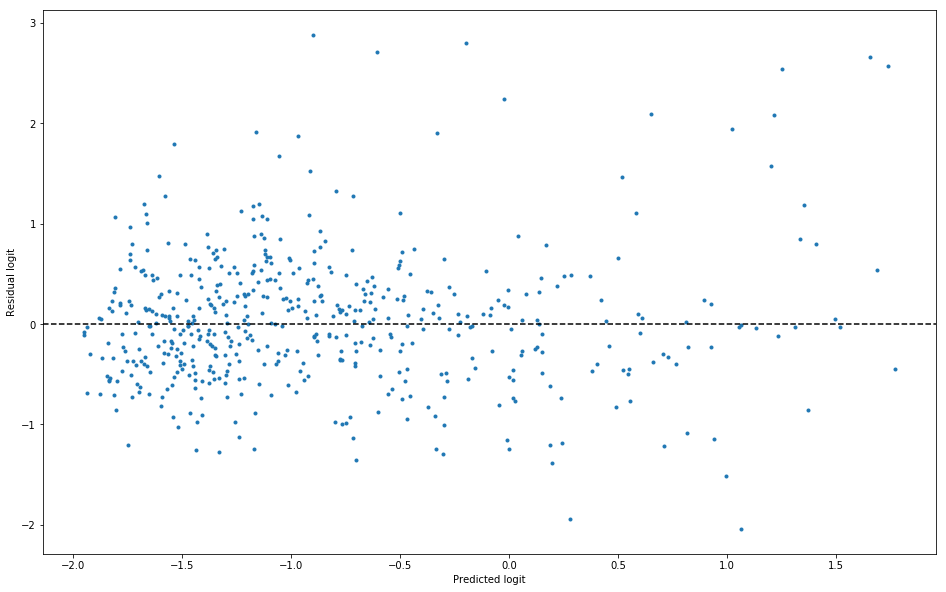

In [12]:
model = HuberRegressor(epsilon=1.15)
model.fit(inputs, outputs)
predictions = model.predict(inputs)
residuals = outputs - predictions

plt.figure(figsize=(16,10))
plt.plot(predictions, residuals, '.')
plt.axhline(0, linestyle='--', color='k')
plt.xlabel("Predicted logit")
plt.ylabel("Residual logit")

print("R2 Score: {}".format(model.score(inputs, outputs)))

Points that are going torwards the lower-right corner of the graph are those with the biggest difference between *expected percentage of SHSAT applicants (logit)* and *actual percentage of SHSAT applicants* and they require the most attention.

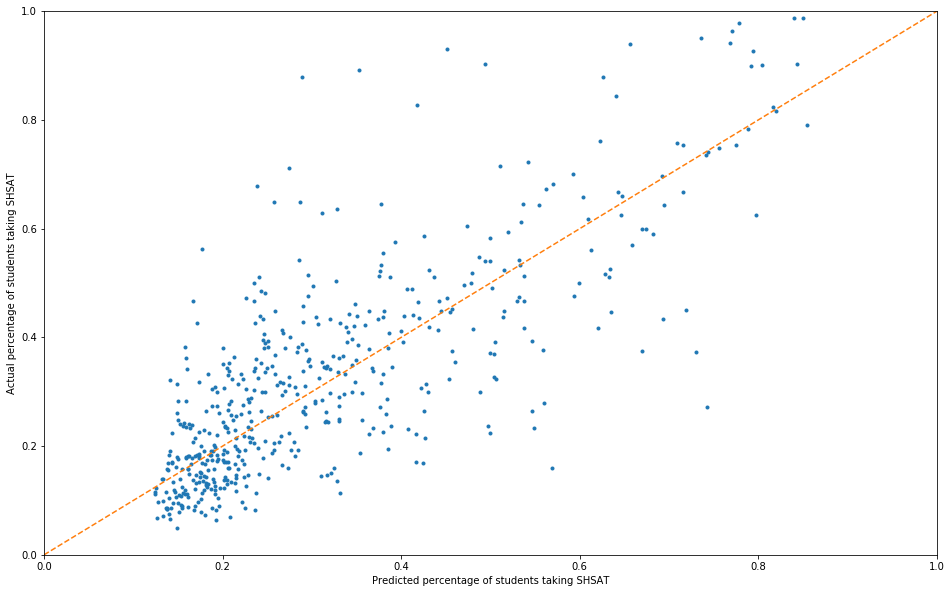

In [13]:
xs = expit(predictions)
ys = expit(outputs)

plt.figure(figsize=(16,10))
plt.plot(xs, ys, '.')
plt.plot([0, 1], [0, 1], '--')
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.xlabel("Predicted percentage of students taking SHSAT")  # compare with HS Admission Process applicants
plt.ylabel("Actual percentage of students taking SHSAT");

In [26]:
pd.Series(model.coef_, index=inputs.columns)

Charter School?                           0.075520
Percent Asian                             0.016924
Percent Black                             0.084306
Percent Hispanic                         -0.069596
Percent Other                             0.000491
Percent English Language Learners        -0.008332
Percent Students with Disabilities       -0.019429
Economic Need Index                       0.004402
Mean Scale Score - ELA                   -0.005450
% Level 2 - ELA                           0.002657
% Level 3 - ELA                           0.021654
% Level 4 - ELA                           0.020994
Mean Scale Score - Math                  -0.002221
% Level 2 - Math                         -0.001963
% Level 3 - Math                          0.009432
% Level 4 - Math                          0.026336
Percent of Students Chronically Absent   -0.008412
dtype: float64

### statsmodels

R2 Score: 0.6041094269840459


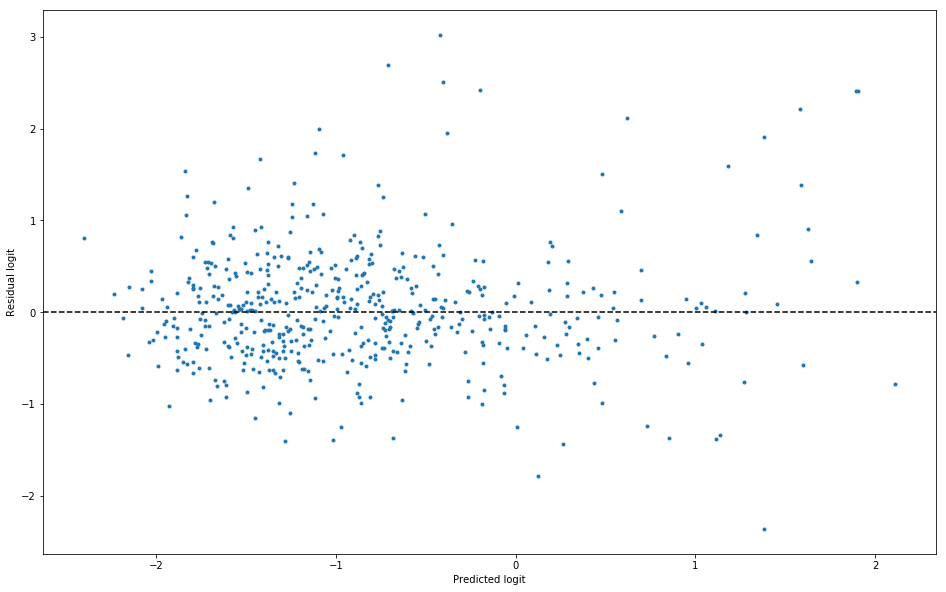

In [22]:
y = outputs.copy()
x = inputs.copy()

x['Constant'] = 1.0
x['Mean Scale Score - ELA ** 2'] = x['Mean Scale Score - ELA'] ** 2
x['Mean Scale Score - Math ** 2'] = x['Mean Scale Score - Math'] ** 2  # TODO: scale before squaring
# x['Mean Scale Score - ELA ** 3'] = x['Mean Scale Score - ELA'] ** 3
# x['Mean Scale Score - Math ** 3'] = x['Mean Scale Score - Math'] ** 3  they start assuming the value of the constant

mod = sm.RLM(y, x, M=sm.robust.norms.HuberT(1.15))
res = mod.fit()
predictions = res.fittedvalues
residuals = outputs - predictions

plt.figure(figsize=(16,10))
plt.plot(predictions, residuals, '.')
plt.axhline(0, linestyle='--', color='k')
plt.xlabel("Predicted logit")
plt.ylabel("Residual logit")

print("R2 Score: {}".format(model.score(inputs, outputs)))

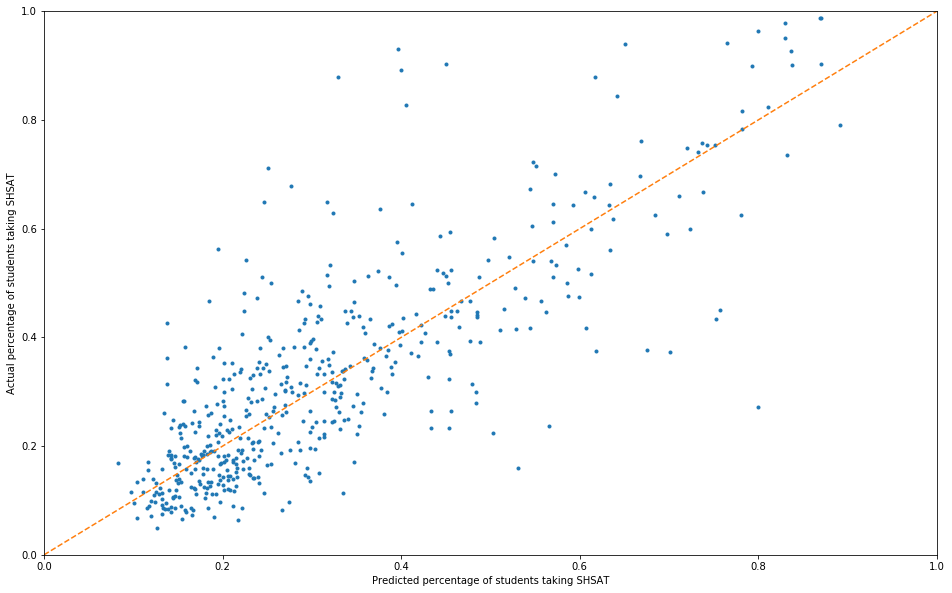

In [23]:
xs = expit(predictions)
ys = expit(outputs)

plt.figure(figsize=(16,10))
plt.plot(xs, ys, '.')
plt.plot([0, 1], [0, 1], '--')
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.xlabel("Predicted percentage of students taking SHSAT")  # compare with HS Admission Process applicants
plt.ylabel("Actual percentage of students taking SHSAT");

In [25]:
res.params

Charter School?                            0.155390
Percent Asian                              0.562755
Percent Black                              0.445303
Percent Hispanic                          -0.241731
Percent Other                              0.050722
Percent English Language Learners          0.296573
Percent Students with Disabilities        -1.563025
Economic Need Index                        0.550346
Mean Scale Score - ELA                     0.018088
% Level 2 - ELA                           -0.008709
% Level 3 - ELA                           -0.001947
% Level 4 - ELA                            0.003049
Mean Scale Score - Math                    0.149808
% Level 2 - Math                          -0.006081
% Level 3 - Math                           0.006725
% Level 4 - Math                           0.031325
Percent of Students Chronically Absent    -0.259463
Constant                                 -28.637957
Mean Scale Score - ELA ** 2                0.000009
Mean Scale S

## Estimate the gap in absolute values

In [27]:
# percentage values
actual_pct = expit(outputs)
estimated_pct = expit(predictions)
residual_pct = actual_pct - estimated_pct

# absolute values (total count)
hs_admissions_counts = hs_admissions_counts.reindex(outputs.index)
actual_cnt = actual_pct * hs_admissions_counts
estimated_cnt = estimated_pct * hs_admissions_counts
residual_cnt = actual_cnt - estimated_cnt

# change
percentual_change = (estimated_pct - actual_pct) / actual_pct

In [28]:
reg_results = pd.DataFrame({
    'Actual #': actual_cnt,
    'Estimated #': np.round(estimated_cnt),
    'Difference #': np.round(residual_cnt),
    
    'Actual %': actual_pct,
    'Estimated %': estimated_pct,
    'Difference %': residual_pct,
    
#     'Percentual Change': percentual_change,  # estimated effort to move from current value to expected value (?)
})

# reg_results.loc[:, :'Difference #'] = reg_results.loc[:, :'Difference #'].applymap(lambda x: "{:.0f}".format(x))
# reg_results.loc[:, 'Actual %':] = reg_results.loc[:, 'Actual %':].applymap(lambda x: "{:.0%}".format(x))

reg_results.head()

,Actual #,Estimated #,Difference #,Actual %,Estimated %,Difference %
DBN,,,,,,
01M034,6.0,8.0,-2.0,0.103448,0.132033,-0.028585
01M140,6.0,8.0,-2.0,0.089552,0.117247,-0.027694
01M184,67.0,59.0,8.0,0.761364,0.668168,0.093196
01M301,11.0,8.0,3.0,0.215686,0.153405,0.062281
01M332,13.0,10.0,3.0,0.191176,0.139794,0.051382


In [29]:
d = pd.read_pickle('../data/process/schools2017.pkl')
d = d.loc[:, :'# Students in HS Admissions']
d = pd.concat([d, reg_results], axis=1, sort=True)
d.head()

,School Name,Charter School?,Borough,Latitude,Longitude,Percent Asian,Percent Black,Percent Hispanic,Percent White,Percent Other,Percent English Language Learners,Percent Students with Disabilities,Percent of Students Chronically Absent,Economic Need Index,Mean Scale Score - ELA,% Level 2 - ELA,% Level 3 - ELA,% Level 4 - ELA,Mean Scale Score - Math,% Level 2 - Math,% Level 3 - Math,% Level 4 - Math,# Students in HS Admissions,Actual #,Estimated #,Difference #,Actual %,Estimated %,Difference %
01M034,P.S. 034 Franklin D. Roosevelt,0.0,manhattan,40.726008,-73.975058,0.053,0.297,0.614,0.030,0.006,0.080,0.380,0.305,0.872,298.2778,59.25926,22.22222,1.851852,285.9423,34.61538,13.46154,0.000000,58.0,6.0,8.0,-2.0,0.103448,0.132033,-0.028585
01M140,P.S. 140 Nathan Straus,0.0,manhattan,40.719148,-73.983769,0.044,0.121,0.794,0.030,0.011,0.124,0.338,0.395,0.853,297.4545,60.00000,21.81818,1.818182,291.2456,38.59649,14.03509,0.000000,67.0,6.0,8.0,-2.0,0.089552,0.117247,-0.027694
01M184,P.S. 184m Shuang Wen,0.0,manhattan,40.711125,-73.985438,0.697,0.044,0.124,0.085,0.050,0.171,0.192,0.041,0.560,330.1358,20.98765,39.50617,34.567900,339.6988,16.86747,28.91566,44.578310,88.0,67.0,59.0,8.0,0.761364,0.668168,0.093196
01M188,P.S. 188 The Island School,0.0,manhattan,40.719888,-73.977380,0.019,0.320,0.625,0.036,0.000,0.154,0.332,0.369,0.938,295.6667,45.09804,15.68627,1.960784,294.5000,46.15385,21.15385,0.000000,59.0,NaN,NaN,NaN,NaN,NaN,NaN
01M301,"Technology, Arts, and Sciences Studio",0.0,manhattan,40.730009,-73.984496,0.087,0.323,0.496,0.055,0.039,0.047,0.441,0.382,0.746,304.7073,46.34146,31.70732,4.878049,288.1951,36.58537,12.19512,2.439024,51.0,11.0,8.0,3.0,0.215686,0.153405,0.062281


In [40]:
d[(d['Borough'] == 'brooklyn') & (d['Actual %'] <= 0.15) & (d['Percent White'] < 0.2)].sort_values('Difference %')

,School Name,Charter School?,Borough,Latitude,Longitude,Percent Asian,Percent Black,Percent Hispanic,Percent White,Percent Other,Percent English Language Learners,Percent Students with Disabilities,Percent of Students Chronically Absent,Economic Need Index,Mean Scale Score - ELA,% Level 2 - ELA,% Level 3 - ELA,% Level 4 - ELA,Mean Scale Score - Math,% Level 2 - Math,% Level 3 - Math,% Level 4 - Math,# Students in HS Admissions,Actual #,Estimated #,Difference #,Actual %,Estimated %,Difference %
19K404,Academy for Young Writers,0.0,brooklyn,40.657266,-73.874064,0.010,0.686,0.288,0.005,0.011,0.026,0.188,0.281,0.740,306.7679,39.28571,26.785710,10.714290,276.8909,23.63636,9.090909,1.818182,72.0,7.0,20.0,-13.0,0.097222,0.274700,-0.177478
84K757,Unity Prep Charter School,1.0,brooklyn,40.686213,-73.940859,0.017,0.768,0.178,0.017,0.020,0.050,0.195,0.177,0.718,304.7941,51.96078,20.588240,8.823529,292.5922,37.86408,18.446600,2.912621,105.0,15.0,31.0,-16.0,0.142857,0.295220,-0.152362
19K422,Spring Creek Community School,0.0,brooklyn,40.657266,-73.874064,0.027,0.719,0.232,0.004,0.018,0.018,0.237,0.271,0.732,306.2308,61.53846,23.076920,3.076923,282.8571,26.98413,7.936508,1.587302,69.0,6.0,15.0,-9.0,0.086957,0.222076,-0.135120
19K171,I.S. 171 Abraham Lincoln,0.0,brooklyn,40.685852,-73.869434,0.057,0.109,0.779,0.020,0.035,0.262,0.190,0.225,0.723,299.0853,41.86047,27.131780,4.651163,288.6028,41.13475,9.219858,0.000000,151.0,11.0,25.0,-14.0,0.072848,0.165979,-0.093132
19K409,East New York Family Academy,0.0,brooklyn,40.661104,-73.886664,0.031,0.684,0.258,0.009,0.018,0.031,0.204,0.155,0.731,304.9853,45.58824,27.941180,7.352941,298.4030,44.77612,20.895520,0.000000,71.0,10.0,17.0,-7.0,0.140845,0.233751,-0.092906
13K266,M.S. K266 - Park Place Community Middle School,0.0,brooklyn,40.678809,-73.976648,0.030,0.789,0.157,0.024,0.000,0.066,0.343,0.280,0.655,304.2667,50.00000,25.000000,3.333333,280.1803,21.31148,4.918033,1.639344,67.0,8.0,14.0,-6.0,0.119403,0.207787,-0.088384
22K109,P.S. 109,0.0,brooklyn,40.635842,-73.933099,0.019,0.773,0.164,0.028,0.016,0.070,0.271,0.236,0.640,300.4432,47.72727,21.590910,3.409091,281.4157,30.33708,8.988764,0.000000,101.0,12.0,20.0,-8.0,0.118812,0.201867,-0.083055
23K522,Mott Hall IV,0.0,brooklyn,40.678124,-73.915106,0.030,0.812,0.152,0.000,0.006,0.048,0.339,0.326,0.824,303.8158,39.47368,34.210530,2.631579,295.2895,39.47368,15.789470,2.631579,61.0,9.0,14.0,-5.0,0.147541,0.230218,-0.082677
84K730,Summit Academy Charter School,1.0,brooklyn,40.677914,-74.005151,0.000,0.310,0.664,0.018,0.008,0.115,0.230,0.325,0.877,303.7297,51.35135,29.729730,2.702703,304.3158,44.73684,18.421050,7.894737,47.0,7.0,11.0,-4.0,0.148936,0.229785,-0.080849
16K057,J.H.S. 057 Whitelaw Reid,0.0,brooklyn,40.691467,-73.932254,0.023,0.620,0.329,0.028,0.000,0.085,0.329,0.370,0.859,299.0714,44.28571,27.142860,1.428571,289.6567,32.83582,10.447760,1.492537,81.0,9.0,15.0,-6.0,0.111111,0.188575,-0.077464


## One school example

In [41]:
d.loc['19K422']

School Name                               Spring Creek Community School
Charter School?                                                       0
Borough                                                        brooklyn
Latitude                                                        40.6573
Longitude                                                      -73.8741
Percent Asian                                                     0.027
Percent Black                                                     0.719
Percent Hispanic                                                  0.232
Percent White                                                     0.004
Percent Other                                                     0.018
Percent English Language Learners                                 0.018
Percent Students with Disabilities                                0.237
Percent of Students Chronically Absent                            0.271
Economic Need Index                                             

This school was selected among the schools with the biggest difference in percentage. Characteristics:

- Located on Brooklyn
- Population mostly Black/Hispanic

Problem: Chronic Absenteeism seems to be being understimated. It is probably really correlated with other features, and we can't do much about it.